### Import Packages

In [472]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import os
import sys
import copy

### Generating the 2-layer stochastic block model

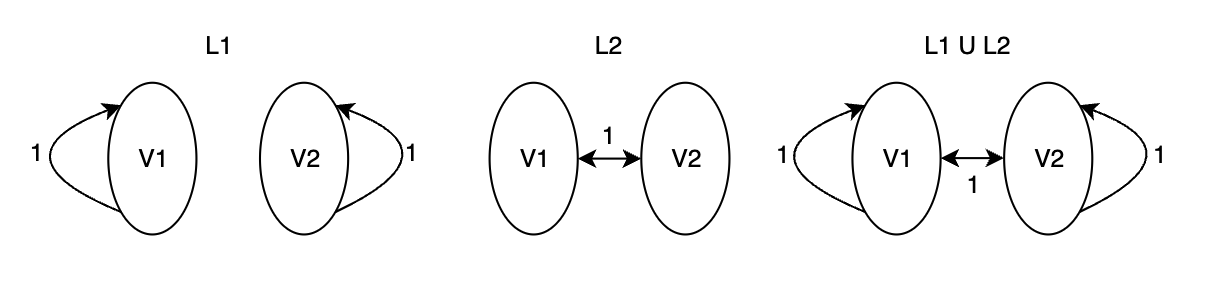

In [473]:
#probability q
_q = 0
#We make two stochastic block models G1(p, _q) and G1(_q, p)
def make_block_model(n = 100, p = 1, seed = 1):
    Ws = []
    true_list = [i for i in range(n)]
    
    #Layer 1 (L1)
    probs = [[p, _q], [_q, p]]
    G1 = nx.stochastic_block_model(sizes=[int(n/2), n-int(n/2)], p=probs, 
                                  seed = seed, nodelist=true_list, directed = False)
    A1 = nx.adjacency_matrix(G1).todense()
    for i in range(n): 
        if np.sum(A1[i,:])==0: A1[i,i] = 1
    Ws.append(torch.from_numpy((A1.T*1/A1.sum(axis = 1).T).T).double())
    
    #Layer 2 (L2)
    probs = [[_q, p], [p, _q]]
    G2 = nx.stochastic_block_model(sizes=[int(n/2), n-int(n/2)], p=probs, 
                                  seed = seed, nodelist=true_list, directed = False)
    A2 = nx.adjacency_matrix(G2).todense()
    for i in range(n): 
        if np.sum(A2[i,:])==0: A2[i,i] = 1
    Ws.append(torch.from_numpy((A2.T*1/A2.sum(axis = 1).T).T).double())
    
    #L1 U L2
    Ws.append((torch.from_numpy(((A1+A2).T*1/(A1+A2).sum(axis = 1).T).T)).double())
    
    return Ws

### Make initial opinions

In [474]:
#Initial Opinions s; nodes in V1 have opinion o1 and nodes in V2 have opinion o2.
def make_initial_opinions(n1 = 50, n2 = 50, o1 = 1, o2 = 0):
    s1 = o1 * np.ones(n1)
    s2 = o2 * np.ones(n2)
    return torch.from_numpy(np.concatenate([s1, s2]))

### Set Resistance and History Parameters (alphas, bettas)

In [475]:
#Resistance parameters alphas; sampled from normal distribution Normal(0.1, 0.1).
def make_resistance_parameters(n = 100, window_size = 2, seed = 1):
    np.random.seed(seed)
    alphabetas = np.random.normal(0.1, 0.1, (n, 1 + window_size))
    for i in range(n):
        for j in range(len(alphabetas[i,:])):
            if alphabetas[i,j] > 1: alphabetas[i,j] = 1
            if alphabetas[i,j] < 0: alphabetas[i,j] = 0
    for i in range(n):
        if np.sum(alphabetas[i,:])<0: 
            for j in range(len(alphabetas[i,:])):
                if alphabetas[i,j] < 0: alphabetas[i,j] = 0
        if np.sum(alphabetas[i,:])>1: alphabetas[i,:] /= np.sum(alphabetas[i,:])
    #if window_size > 0:
    #    alphabetas[:,1:] *= 0#0.1 - np.random.normal(0.05, 0.05, alphabetas[:,1:].shape)
    return torch.from_numpy(alphabetas)

### Set Layer Parameters (lambdas)

In [476]:
#Layer parameters lambdas = (lambda1, lambda2).T with lambda1 + lambda2 = 1.
def make_layer_parameters(n = 100, l = 0.8):
    lambda1 = l
    lambda2 = 1 - l
    return torch.from_numpy(np.array([lambda1, lambda2]))

### Predictions
$$x_u(t)=\alpha_us_u+\sum\limits_{i\in[t_{\min},t_{\max}]}\beta_u(i)x_u(t-i)+\left(1-\alpha_u-\sum\limits_{i\in[t_{\min},t_{\max}]}\beta_u(i)\right)\sum\limits_{\ell\in[L]}\lambda_{\ell}\mathbf{w}^{\top}_{l,u}\mathbf{x}(t-1)$$

In [477]:
#Given initial opinions (s), the resistance parameters (alphas),
#the layer weights (lambdas), the weighted adjacency matrices (W) and 
#opinions in [t-window_size] (xts), function returns opinions at t+1 (x(t+1)).
def predict(s, alphabetas, lambdas, window_size, W, xts):
    n = len(s)
    xt_plus_1 = alphabetas[:,0].reshape(n,1)*s.reshape(n,1)
    if window_size>0:
        xt_plus_1 += torch.diag(alphabetas[:,1:].reshape(n, window_size)@xts.T).reshape(n,1)
    for u in range(n): 
        for l in range(len(lambdas)):
            xt_plus_1[u,0] += float((1-torch.sum(alphabetas[u,:]))*lambdas[l]*(W[l][u,:].reshape(1,n)@xts[:,-1]))
    return xt_plus_1

### Generate data using Multilayer FJ model.

In [478]:
def make_train_and_test_data(n = 5, p = 1, l = 1/4, T = 8, window_size=1, seed = 1):
    data = {}
    #model parameters
    data['W'] = make_block_model(n, p, seed)
    data['s'] = make_initial_opinions(int(n/2), n - int(n/2)).double()
    data['alphabetas'] = make_resistance_parameters(n, window_size, seed).double()
    data['lambdas'] = make_layer_parameters(l).double()
    
    #generating data
    data['x'] = []
    colnums = max(1,window_size)
    X = torch.zeros((n, colnums))
    for w in range(colnums):
        X[:,w] = data['s']
    data['x'].append(X)
    
    if False:
        print('-----------------------')
        print('X data:')
        print('-----------------------')
        print(X)
        print('-----------------------')
        print('W matrices')
        print('-----------------------')
        print(data['W'][0])
        print(data['W'][1])
        print('Alpha and Bests')
        print('-----------------------')
        print(data['alphabetas'])
        print('Lambdas')
        print('-----------------------')
        print(data['lambdas'])

        #check dimensions
        print(data['W'][0].shape)
        print(data['s'].shape)
        print(data['alphabetas'].shape)
        print(data['lambdas'].shape)
        print(data['x'][-1].shape)
    
    
    for _ in range(T): 
        pred = predict(data['s'], data['alphabetas'], data['lambdas'], window_size, data['W'][0:2], data['x'][-1].double())
        data['x'].append(torch.zeros((n, colnums)))
        data['x'][-1][:,:-1] = data['x'][-2][:,1:]
        data['x'][-1][:,-1] = pred.reshape(-1)
        #print(data['x'][-1])
    #return parameters and data
    return data

### Make the dataset

In [479]:
iters = 10
T = 10
window_size = 1
dataset = []
for i in range(iters): 
    dataset.append(make_train_and_test_data(n = 100, seed = 100*i+int(1*10), T=T, window_size = window_size))

### Projected Gradient Descent  (PGD)

In [480]:
import numpy as np
from numpy import linalg as LA
import torch
import torch.nn as nn
import cvxpy as cp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TensorSolver:
    #Init Function
    def __init__(self, b, window_size, Ws, x, y, loss_function = torch.nn.L1Loss()):
        #number of nodes
        self.n = len(Ws[0])
        #number of layers
        self.L =  len(Ws)
        #number of timestamps
        self.T = len(x)
        #window_size
        self.window_size = window_size
        #Unknown variables: 
        # first column are biased-lambdas 
        # second window_size are memory-lambdas
        self.alphabetas = torch.from_numpy(np.ones((self.n, self.window_size+1))/(self.window_size+1+1)).to(device)
        self.alphabetas[:,0] = 1
        self.alphabetas[:,1:] = 0
        self.alphabetas.requires_grad_(True)
        # lambdas are layer-lambdas
        self.lambdas = torch.from_numpy(np.ones((self.L, 1))/self.L).to(device)
        self.lambdas.requires_grad_(True)
        #Loss function
        self.criterion = loss_function
        #biases
        self.b = b
        #stochastic matrices
        self.Ws = Ws
        #input
        self.x = x
        #output
        self.y = y
        

    #Predict Function 
    def pred(self, t = 0):
        prediction = self.alphabetas[:,0].reshape(-1,1)*self.b
        if window_size>0:
            prediction += torch.diag(self.alphabetas[:,1:]@self.x[t].T).reshape(-1,1)
        for l in range(self.L): 
            prediction += self.lambdas[l,0]*(self.Ws[l]*((1-torch.sum(self.alphabetas, axis=1).reshape(-1,1))@torch.ones((1,self.n)).double()))@(self.x[t][:,-1].reshape(-1,1))
        return prediction    


    #Loss Function
    def loss(self, T=None):
        if T is not None: toprint = True
        if T is None: T = self.T
        squared_all = 0
        for t in range(T):
            squared_all = squared_all + (1/self.T)*self.criterion(self.pred(t), self.y[t])
        return squared_all
    
    
    #L1
    def lossL1(self, T=None):
        if T is not None: toprint = True
        if T is None: T = self.T
        squared_all = 0
        for t in range(T):
            squared_all = squared_all + (1/self.T)*torch.nn.L1Loss()(self.pred(t), self.y[t])
        return squared_all
    
    
    #Gradient Descent
    def gradient(self, lr = 1):
        if self.alphabetas.requires_grad and self.lambdas.requires_grad:
            self.loss().backward()
            self.alphabetas.data  -= lr*self.alphabetas.grad.data
            self.lambdas.data  -= lr*self.lambdas.grad.data
            self.projection_new()


    #Projection to feasible solution
    def projection_new(self):
        self.lambdas.grad.zero_()
        Lambdas = self.lambdas.data
        Lnew = cp.Variable(Lambdas.shape)
        prob = cp.Problem(cp.Minimize(cp.sum_squares(Lambdas - Lnew)),
                          [Lnew >= 0,
                           Lnew <= 1,
                           cp.sum(Lnew[-self.L:])==1])
        prob.solve()
        self.lambdas = torch.tensor(Lnew.value)
        self.lambdas.requires_grad_()    
        
        
        self.alphabetas.grad.zero_()
        Alphabetas = self.alphabetas.data
        Alphabetasnew = cp.Variable(Alphabetas.shape)
        prob = cp.Problem(cp.Minimize(cp.sum_squares(Alphabetas - Alphabetasnew)),
                          [Alphabetasnew >= 0,
                           Alphabetasnew <= 1,
                           cp.sum(Alphabetasnew, axis=1)<=np.ones(len(Alphabetas))])
        prob.solve()
        self.alphabetas = torch.tensor(Alphabetasnew.value)
        #self.alphabetas[:,-1] = torch.ones(len(self.alphabetas[:,-1]))
        #self.alphabetas[:,0] = torch.zeros(len(self.alphabetas[:,0]))
        self.alphabetas.requires_grad_()  
        
    
    
    #Training Phase
    def training(self, num_epochs = 500, lrdiv = 5, printall = True, printL1 = True): 
        if printall: 
            if printL1: print('Initial: ',self.lossL1().item())
            else: print('Initial: ',self.loss().item())
        training_loss = []
        for epoch in range(num_epochs):
            lr = lrdiv#self.n/lrdiv
            self.gradient(lr=lr) 
            lossval = 0
            if printL1: lossval = self.lossL1().item()
            else: lossval = self.loss().item()
            training_loss.append(lossval)
            if printall:
                if epoch % 1 == 0:
                    print(f"Epoch: {epoch}, L1 loss {lossval:.8}")
                    print(f"Epoch: {epoch}, L2 loss {self.loss().item():.8}")
                    print()
        return training_loss

    
    #Testing Phase
    def test(self, Ws, x, y):
        #number of nodes
        self.n = len(Ws[0])
        #number of layers
        self.L =  len(Ws)
        #number of timestamps
        self.T = len(Ws)
        #Loss function
        #self.criterion = torch.nn.MSELoss()
        self.criterion = torch.nn.L1Loss()
        #input
        self.x = x
        #output
        self.y = y
        return self.loss(T=len(y)) 



In [486]:
#Run the experiments
def run_the_experiments(data_, T_train, T_test, window_size, algname = 'multi'):
    results = {}
    results['train_loss'] = []
    results['train_epoch'] = []
    results['test_loss'] = []
    results['alphabetas'] = []
    results['lambdas'] = []
    for i in range(len(data_)):
        data = copy.deepcopy(data_)
        Ws_ = copy.deepcopy(data[i]['W'])
        n = len(Ws_[0])
        print(f'Algorithm {algname}')
        if algname == 'multi': Ws_ = [data[i]['W'][0], data[i]['W'][1]]
        elif algname == 'l1': Ws_ = [data[i]['W'][0], data[i]['W'][0]]
        elif algname == 'l2': Ws_ = [data[i]['W'][1], data[i]['W'][1]]
        elif algname == 'lboth': Ws_ = [data[i]['W'][2], data[i]['W'][2]]
        else: return
        colnum = max(1, window_size)
        x_train = [data[i]['x'][j].reshape(n, colnum).double() for j in range(0,T_train)]
        y_train = [data[i]['x'][j][:,-1].reshape(n, 1).double() for j in range(1,T_train+1)]
        x_test = [data[i]['x'][j].reshape(n, colnum).double() for j in range(T_train, T_train+T_test)]
        y_test = [data[i]['x'][j][:,-1].reshape(n, 1).double() for j in range(T_train+1, T_train+T_test+1)]
        
        solver  = TensorSolver(data[i]['s'].reshape(n,1), window_size, Ws_, x = x_train, y = y_train)
        train_loss = solver.training(num_epochs = 500, lrdiv = 0.75, printall = False, printL1 = True) #change False to True for printing loss
        test_loss = []
        #s, alphabetas, lambdas, window_size, W, xts
        for t in range(T_test):
            test_loss.append(torch.nn.L1Loss()(predict(data[i]['s'].reshape(n,1), 
                                                       solver.alphabetas.detach(),
                                                       solver.lambdas.detach().reshape(-1),
                                                       window_size,
                                                       Ws_, 
                                                       x_test[t]).reshape(n,1), y_test[t].reshape(n,1)).numpy())
        print('Test Loss: ', test_loss)
        results['train_epoch'].append(train_loss)
        results['test_loss'].append(np.mean(test_loss))
        results['alphabetas'].append(solver.alphabetas.detach().numpy())
        results['lambdas'].append(solver.lambdas.detach().numpy())
        
        train_loss = []
        for t in range(T_train):
            prediction = predict(data[i]['s'].reshape(n,1), 
                                 solver.alphabetas.detach(),
                                 solver.lambdas.detach().reshape(-1),
                                 window_size,
                                 Ws_, 
                                 x_train[t]).reshape(n,1)
            train_loss.append(torch.nn.L1Loss()(prediction, y_train[t].reshape(n,1)).numpy())
        results['train_loss'].append(np.mean(train_loss))
    return results

T_train = 5
T_test = 5
alg_results = {}
for algname in ['multi', 'l1', 'l2', 'lboth']: 
    alg_results[algname] = run_the_experiments(dataset, T_train, T_test, window_size, algname)

Algorithm multi
Test Loss:  [array(0.02826321), array(0.03073915), array(0.03216264), array(0.03298169), array(0.03345349)]
Algorithm multi
Test Loss:  [array(0.0281679), array(0.03077848), array(0.03230108), array(0.03318904), array(0.03370682)]
Algorithm multi
Test Loss:  [array(0.02704749), array(0.02937497), array(0.030719), array(0.03149329), array(0.03193773)]
Algorithm multi
Test Loss:  [array(0.03635472), array(0.03845195), array(0.03967075), array(0.04037916), array(0.04079101)]
Algorithm multi
Test Loss:  [array(0.02896945), array(0.03164148), array(0.03322493), array(0.03416426), array(0.03472239)]
Algorithm multi
Test Loss:  [array(0.0333159), array(0.03544488), array(0.03668655), array(0.03741365), array(0.03784202)]
Algorithm multi
Test Loss:  [array(0.02906237), array(0.03178527), array(0.033392), array(0.03434006), array(0.03489943)]
Algorithm multi
Test Loss:  [array(0.02939571), array(0.03218838), array(0.03384714), array(0.03483534), array(0.0354267)]
Algorithm multi

### Average results

In [487]:
for algname in alg_results:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_epoch_mean'] = np.mean(alg_results[algname]['train_epoch'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphabetas_mean'] = np.mean(alg_results[algname]['alphabetas'], axis = 0)
    alg_results[algname]['lambdas_mean'] = np.mean(alg_results[algname]['lambdas'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_epoch_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphabetas_std'] = np.std(alg_results[algname]['alphabetas'], axis = 0)
    alg_results[algname]['lambdas_std'] = np.std(alg_results[algname]['lambdas'], axis = 0)

### Plot average train loss vs epochs

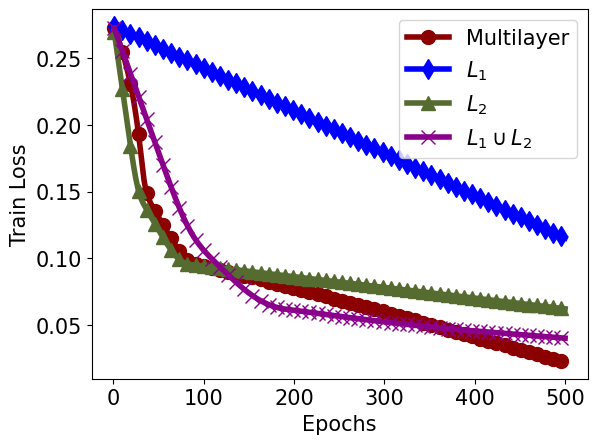

In [488]:
def plot_train_loss(alg_results):
    fig, axes = plt.subplots(1)
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    markers = ["o", "d", "^", "x"]
    ax1 = axes
    j = 0
    for algname in alg_results:
        ax1.plot(range(1, len(alg_results[algname]['train_epoch_mean']) + 1), 
                 alg_results[algname]['train_epoch_mean'], 
                 color = m[j], label = names_plot[j],linewidth=4.0,
                 marker = markers[j], markevery=9, markersize=10)
        j += 1
    plt.legend(fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Train Loss', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/train_loss_synthetic.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_train_loss(alg_results)

### Plot average test loss 

multi -> 0.023160112254791393
l1 -> 0.11527709173996348
l2 -> 0.06236359989633159
lboth -> 0.04040295406402271


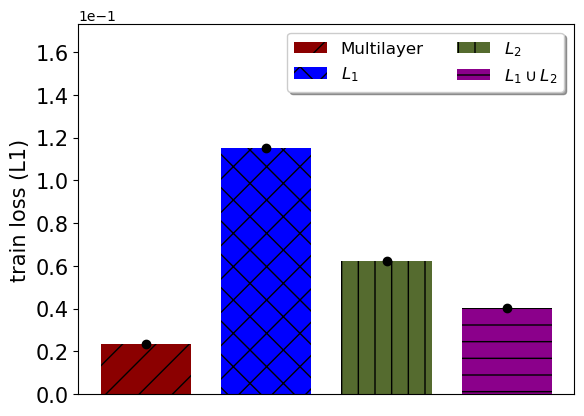

multi -> 0.03388376590527062
l1 -> 0.08625814962840288
l2 -> 0.11028644481085001
lboth -> 0.04955419807898014


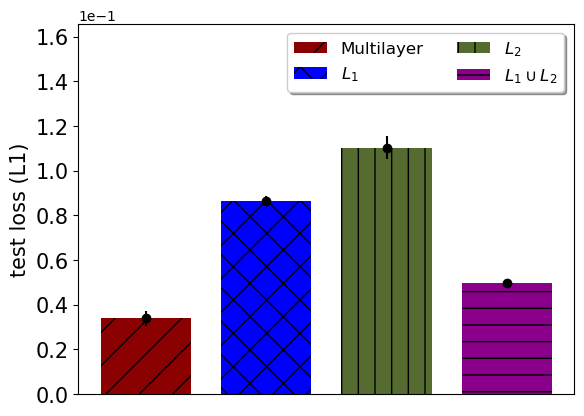

In [489]:
def plot_loss(alg_results, name_ = 'test'):
    fig, axes = plt.subplots()
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$', 'GCN', 'ARIMA', 'Naive']
    #d = ['lightcoral', 'cornflowerblue', 'lightgreen', 'pink', '']
    #c = ['indianred', 'royalblue', 'greenyellow', 'hotpink']
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta', 'lightcoral', 'hotpink', 'lightgreen']
    hatches = ['/', 'x', '|', '-', '+', '*', '\\']
    i = 0
    max_ = -1
    for algname in alg_results:
        x = np.arange(1)  # the label locations
        width = 0.15      # the width of the bars
        offset = width * i
        max_ = max(alg_results[algname][f'{name_}_loss_mean'], max_)
        print(f'{algname} -> {alg_results[algname][f"{name_}_loss_mean"]}')
        axes.bar(x + offset, alg_results[algname][f'{name_}_loss_mean'], 3*width/4,
                label=names_plot[i], color = m[i],
                hatch=hatches[i])
        axes.errorbar(x + offset, alg_results[algname][f'{name_}_loss_mean'],
                      alg_results[algname][f'{name_}_loss_std'],
                            fmt="o", color='black')
        i += 1
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    plt.ylim(top=max_+0.5*max_)
    plt.ylim(bottom=0)
    plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.7, 1.0),
          ncol=2, fancybox=True, shadow=True)
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,-1))
    plt.ylabel(f'{name_} loss (L1)', fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/test_loss_synthetic.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_loss(alg_results, 'train')
plot_loss(alg_results, 'test')

### Plot distribution of average predicted alphas  

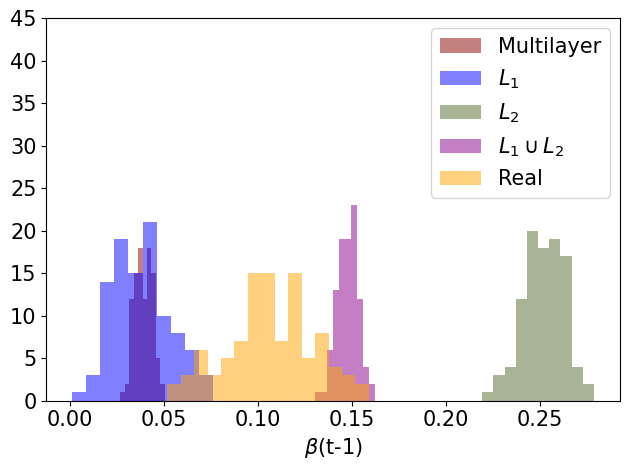

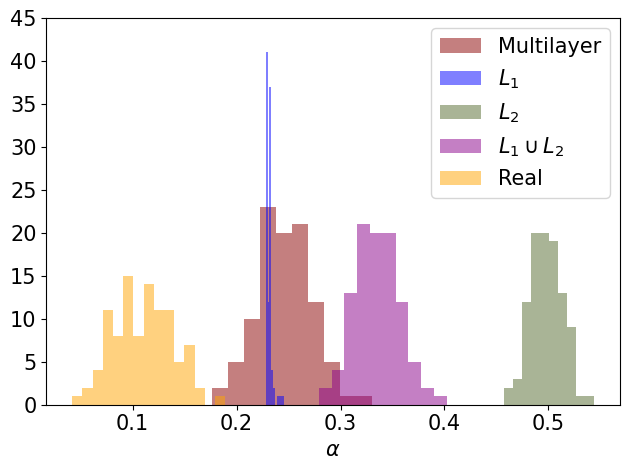

In [490]:
def plot_alphas_distribution(alg_results):
    colors = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    for k in range(window_size, -1, -1):
        i = 0
        for algname in alg_results:
            plt.hist(np.array(alg_results[algname]['alphabetas_mean'][:,k]), bins=10, 
                     color = colors[i] ,label = names_plot[i], alpha = 0.5)
            i += 1
            
        real_alphabetas_mean = np.zeros(len(dataset[0]['alphabetas']))
        for l in range(len(dataset)):
            real_alphabetas_mean += ((dataset[l]['alphabetas'][:,k].numpy())/len(dataset)).reshape(-1)
        plt.hist(np.array(real_alphabetas_mean), bins=15, 
                 color = 'orange', label = 'Real', alpha = 0.5)
        plt.ylim(top=45)
        plt.legend()
        plt.legend(fontsize=15)
        if k == 0:
            plt.xlabel(r'$\alpha$', fontsize=15)
        else: 
            t = k-window_size+1
            plt.xlabel(r'$\beta$'f'(t-{t})', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.tight_layout()
        plt.savefig(f'./Figures/alpha_distribution_synthetic.png', bbox_inches='tight', dpi=1000)
        plt.show()

plot_alphas_distribution(alg_results)

### Predicted layer parameters

In [491]:
for algname in alg_results:
    print(f'For {algname} lambdas are: {alg_results[algname]["lambdas_mean"].T[0]}')

For multi lambdas are: [0.71280664 0.28719336]
For l1 lambdas are: [0.5 0.5]
For l2 lambdas are: [0.5 0.5]
For lboth lambdas are: [0.5 0.5]


## GCN
The residual gated graph convolutional operator from the “Residual Gated Graph ConvNets” paper.
\begin{equation}
\mathbf{x}'_i = \mathbf{W}_1 \mathbf{x}_i + \sum_{j \in \mathcal{N}(i)} \eta_{i,j} \odot \mathbf{W}_2 \mathbf{x}_j
\end{equation}
 
where the gate $\eta_{i,j}$
 is defined as

\begin{equation}
\eta_{i,j} = \sigma (\mathbf{W}_3 \mathbf{x}_i + \mathbf{W}_4 \mathbf{x}_j)
\end{equation}

with $\sigma$
 denoting the sigmoid function.

In [492]:
import torch
from torch.nn import Linear
from torch_geometric.nn import ResGatedGraphConv


class GCN(torch.nn.Module):
    def __init__(self, numfeat = -1):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = ResGatedGraphConv(numfeat, 64, bias = True)
        self.conv2 = ResGatedGraphConv(64, 32, bias = True)
        self.conv3 = ResGatedGraphConv(32, 16, bias = True)
        self.classifier = Linear(16, 1, bias=True)
        

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)
        return out, h
    
def train_my_model(model, x_train, y_train, edge_index, criterion, optimizer):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(x_train, edge_index)  # Perform a single forward pass.
    loss = criterion(out, y_train)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

def test_my_model(model, x_test, y_test, edge_index, criterion):
    list_of_losses = []
    for k in range(len(x_test)):
        out, h = model(x_test[k,:,:], edge_index)  # Perform a single forward pass.
        loss = criterion(out, y_test[k,:,:])  # Compute the loss solely based on the training nodes.
        list_of_losses.append(loss.detach().numpy())
    return list_of_losses

In [493]:
alg_results['gnn'] = {'train_loss':[]}
alg_results['gnn']['test_loss'] = []
for kk in range(len(dataset)):
    n = len(dataset[kk]['s'])
    T_train = 5
    T_test = 5
    x_train = torch.zeros((T, n, max(1,window_size) + 1))
    y_train = torch.zeros((T, n, 1))
    for i in range(T_train):
        x_train[i,:,0] = dataset[kk]['s']
        x_train[i,:,1:] = dataset[kk]['x'][i]

        y_train[i,:,0] = dataset[kk]['x'][i+1][:,-1]

    x_test = torch.zeros((T, n, max(1,window_size) + 1))
    y_test = torch.zeros((T, n, 1))
    for i in range(T_train, T_train+T_test):
        x_test[i-T_train,:,0] = dataset[kk]['s']
        x_test[i-T_train,:,1:] = dataset[kk]['x'][i]

        y_test[i-T_train,:,0] = dataset[kk]['x'][i+1][:,-1]

    Ws = dataset[kk]['W'][2]
    edge_index = [[],[]]
    for _ in range(1):
        for i in range(Ws.shape[0]):
            for j in range(Ws.shape[0]):
                if Ws[i][j]>0:
                    edge_index[0].append(int(i))
                    edge_index[1].append(int(j))
    edge_index=torch.sparse.Tensor(edge_index).to(torch.int64)
    
    model = GCN()
    #criterion = torch.nn.MSELoss() 
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Initialize the Adam optimizer.

    for epoch in range(100):
        loss, h = train_my_model(model, x_train, y_train, edge_index, criterion, optimizer)
        if epoch%10==0: print(f'Epoch: {epoch}, Train Loss: {loss}')

    train_of_losses = test_my_model(model, x_train, y_train, edge_index, criterion = torch.nn.L1Loss())
    test_of_losses = test_my_model(model, x_test, y_test, edge_index, criterion = torch.nn.L1Loss())

    alg_results['gnn']['train_loss'].append(np.mean(train_of_losses))
    alg_results['gnn']['test_loss'].append(np.mean(test_of_losses))
    
    print(f'Train Loss: {np.mean(train_of_losses)}')
    print(f'Test Loss: {np.mean(test_of_losses)}')

for algname in ['gnn']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

Epoch: 0, Train Loss: 0.20539738237857819
Epoch: 10, Train Loss: 0.15699578821659088
Epoch: 20, Train Loss: 0.15928393602371216
Epoch: 30, Train Loss: 0.1376664936542511
Epoch: 40, Train Loss: 0.12122255563735962
Epoch: 50, Train Loss: 0.11772088706493378
Epoch: 60, Train Loss: 0.12592343986034393
Epoch: 70, Train Loss: 0.12515752017498016
Epoch: 80, Train Loss: 0.1370438039302826
Epoch: 90, Train Loss: 0.12237666547298431
Train Loss: 0.11680742353200912
Test Loss: 0.07541783154010773
Epoch: 0, Train Loss: 0.20368191599845886
Epoch: 10, Train Loss: 0.12157899141311646
Epoch: 20, Train Loss: 0.11770115792751312
Epoch: 30, Train Loss: 0.12597724795341492
Epoch: 40, Train Loss: 0.1231410875916481
Epoch: 50, Train Loss: 0.12808389961719513
Epoch: 60, Train Loss: 0.1300969421863556
Epoch: 70, Train Loss: 0.12241961061954498
Epoch: 80, Train Loss: 0.11865079402923584
Epoch: 90, Train Loss: 0.11387892067432404
Train Loss: 0.11685504764318466
Test Loss: 0.07356659322977066
Epoch: 0, Train Loss

multi -> 0.023160112254791393
l1 -> 0.11527709173996348
l2 -> 0.06236359989633159
lboth -> 0.04040295406402271
gnn -> 0.1220168024301529


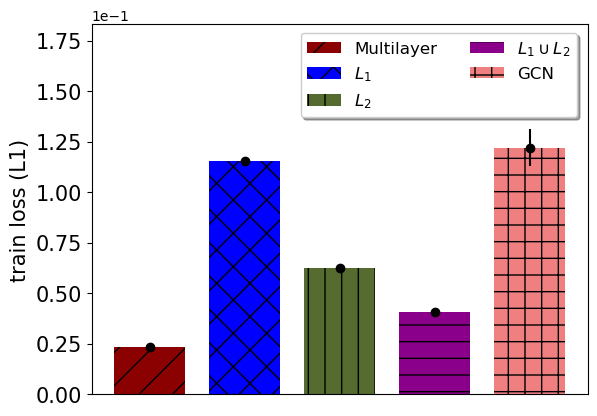

multi -> 0.03388376590527062
l1 -> 0.08625814962840288
l2 -> 0.11028644481085001
lboth -> 0.04955419807898014
gnn -> 0.0924544483423233


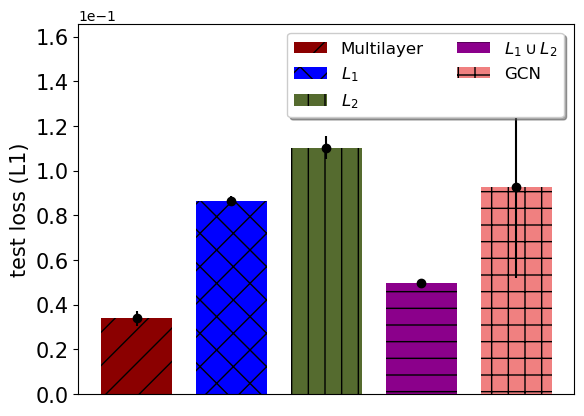

In [494]:
plot_loss(alg_results, 'train')
plot_loss(alg_results, 'test')

## ARIMA

In [496]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

alg_results['arima'] = {'train_loss':[]}
alg_results['arima']['test_loss'] = []

for kk in range(len(dataset)):
    X_arima = np.zeros((T_train+T_test+1, n))
    for i in range(T_train+T_test+1):
        X_arima[i,:] = dataset[kk]['x'][i][:,-1]


    arima_train_loss = np.zeros(T_train)
    arima_test_loss = np.zeros(T_test)
    start_pos = 0

    for node in range(n):
        with warnings.catch_warnings():
            preds = []
            for i in range(T_train):
                warnings.simplefilter("ignore")
                if i==0: preds.append(X_arima.T[node][0])
                else:
                    if i<=1: mod = ARIMA(X_arima.T[node][:i+1], order=(1, 0, 0))
                    else: mod = ARIMA(X_arima.T[node][:i+1], order=(1, 1, 1))
                    mod.initialize_approximate_diffuse()
                    model_fit = mod.fit()
                    preds.append(model_fit.forecast(1)[0])
                #print(f'trained in first {T_train+i+1} elements, prediction of {T_train+i+1}')
            arima_train_loss += np.abs(preds-X_arima.T[node][1:T_train+1])

            preds = []
            for i in range(T_test):
                warnings.simplefilter("ignore")
                mod = ARIMA(X_arima.T[node][:T_train+i+1], order=(1, 1, 1))
                mod.initialize_approximate_diffuse()
                model_fit = mod.fit()
                preds.append(model_fit.forecast(1)[0])

            arima_test_loss += np.abs(preds-X_arima.T[node][T_train+1:T_train+T_test+1])


    arima_train_loss = arima_train_loss/n
    arima_test_loss = arima_test_loss/n
    
    print(arima_train_loss)
    print(arima_test_loss)
    
    alg_results['arima']['train_loss'].append(np.mean(arima_train_loss))
    alg_results['arima']['test_loss'].append(np.mean(arima_test_loss))

for algname in ['arima']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

[0.1540716  0.08651414 0.00462031 0.00332206 0.00183816]
[0.00070939 0.00060141 0.00038207 0.00043593 0.00028909]
[0.15591523 0.08909544 0.00496424 0.00361541 0.00187605]
[0.00070762 0.00059642 0.00028245 0.00021042 0.00013157]
[0.15850529 0.08923427 0.00509275 0.00363253 0.00198884]
[0.00074054 0.00079149 0.00060064 0.00055898 0.00032165]
[0.1558391  0.08874657 0.00488269 0.0036676  0.00192414]
[0.00073183 0.00058045 0.00039487 0.00047767 0.00035616]
[0.15804838 0.09176654 0.00498511 0.0035978  0.00199222]
[0.00076121 0.00077543 0.00055406 0.00052426 0.0003577 ]
[0.15724582 0.08922225 0.0049196  0.00358286 0.00187906]
[0.00077199 0.000679   0.00052734 0.00047419 0.00032947]
[0.15711868 0.08981846 0.00585086 0.00431822 0.00223144]
[0.00089222 0.00067109 0.00036835 0.00038086 0.00023963]
[0.15644806 0.08951998 0.00634424 0.00462117 0.00275921]
[0.00092693 0.00116453 0.00071125 0.00067405 0.00041348]
[0.15999005 0.09132561 0.00511342 0.00367549 0.00209788]
[0.00077051 0.00065139 0.000456

## NAIVE APPROACH

In [497]:
alg_results['naive'] = {'train_loss':[]}
alg_results['naive']['test_loss'] = []

for kk in range(len(dataset)):
    X_naive = np.zeros((T_train+T_test+1, n))
    for i in range(T_train+T_test+1):
        X_naive[i,:] = dataset[kk]['x'][i][:,-1]

    naive_train_loss = []
    naive_test_loss = []

    for i in range(T_train):
        print(np.mean(np.abs(X_naive[i,:]-X_naive[i+1,:])))
        naive_train_loss.append(np.mean(np.abs(X_naive[i,:]-X_naive[i+1,:])))

    for i in range(T_train, T_train+T_test):
        naive_test_loss.append(np.mean(np.abs(X_naive[i,:]-X_naive[i+1,:])))

    print(naive_train_loss)
    print(naive_test_loss)

    alg_results['naive']['train_loss'].append(np.mean(naive_train_loss))
    alg_results['naive']['test_loss'].append(np.mean(naive_test_loss))

for algname in ['naive']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

0.1540716038644314
0.08605654790997505
0.049016124606132506
0.028050854355096817
0.016083250492811202
[0.1540716038644314, 0.08605654790997505, 0.049016124606132506, 0.028050854355096817, 0.016083250492811202]
[0.009230595231056214, 0.005301302075386047, 0.003046611249446869, 0.0017522415518760681, 0.00100888654589653]
0.1559152315557003
0.08862975791096687
0.05137618348002434
0.02990504041314125
0.01742995321750641
[0.1559152315557003, 0.08862975791096687, 0.05137618348002434, 0.02990504041314125, 0.01742995321750641]
[0.010163814425468445, 0.005927902162075043, 0.003457653820514679, 0.0020168891549110415, 0.0011765095591545105]
0.1585052938014269
0.08918644703924655
0.051256855130195615
0.02962203398346901
0.01716321051120758
[0.1585052938014269, 0.08918644703924655, 0.051256855130195615, 0.02962203398346901, 0.01716321051120758]
[0.009961543083190917, 0.0057908594608306885, 0.003372693806886673, 0.0019693662226200103, 0.0014035946130752563]
0.15583910033106804
0.08834378734230995
0.

multi -> 0.023160112254791393
l1 -> 0.11527709173996348
l2 -> 0.06236359989633159
lboth -> 0.04040295406402271
gnn -> 0.1220168024301529
arima -> 0.05138557050237528
naive -> 0.06889856213629246


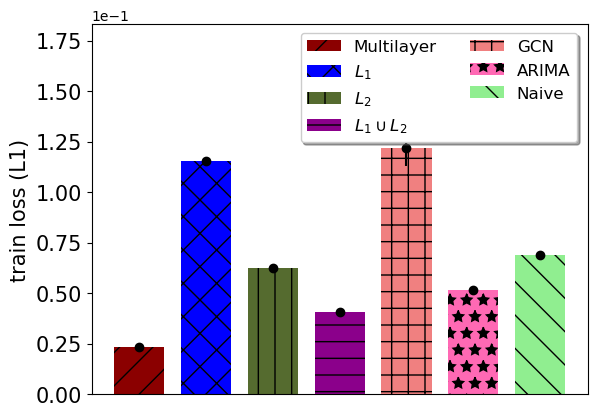

multi -> 0.03388376590527062
l1 -> 0.08625814962840288
l2 -> 0.11028644481085001
lboth -> 0.04955419807898014
gnn -> 0.0924544483423233
arima -> 0.0005599214947120688
naive -> 0.004617151519656181


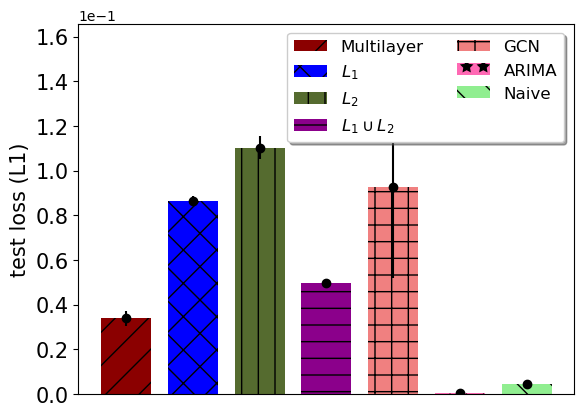

In [498]:
plot_loss(alg_results, 'train')
plot_loss(alg_results, 'test')